In [2]:
import sklearn.datasets
import urllib.request
from typing import Callable

import numpy as np
from proxskip.types import ProximityOperator, Vector, Function, Session
from proxskip.algorithm import Algorithm

In [3]:
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"

data_path = './w8a'
f = urllib.request.urlretrieve(w8a_url, data_path)
# f = urllib.request.urlretrieve(a9a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

In [4]:
A.shape, b.shape

((49749, 300), (49749,))

In [7]:
norm_sum_ = np.zeros_like(*A.shape[1:], dtype=np.float32)
for i in range(A.shape[0]):
    norm_sum_ += np.linalg.norm(A[i].toarray()) ** 2
norm_sum = norm_sum_ / A.shape[0] / 4
norm_sum

2.9125510060503728

In [8]:
class DistrubutedLogisticRegression(Function):
    def __init__(self, X, y, lambda_: float, num_devices: int):
        self.X = X
        self.y = y
        self.lambda_ = lambda_
        self.n, self.d = X.shape
        self.num_devices = num_devices
        
        self.Xs = np.split(self.X, self.num_devices)
        self.ys = np.split(self.y, self.num_devices)
        self.ns = [X.shape[0] for X in self.Xs]
        self.ds = [X.shape[1] for X in self.Xs]
        
        self.L = []
        for device in range(self.num_devices):
            sum_ = np.zeros_like(self.Xs[device].shape[1:], dtype=np.float32)
            for i in range(self.ns[device]):
                sum_ += np.linalg.norm(self.Xs[device][i].toarray()) ** 2
            self.L.append(sum_ / self.ns[device] / 4)
            
        self.L = np.array(self.L)
            
        self.ws = []
    

In [9]:
class L1Norm(ProximityOperator):
    def __call__(
        self, 
        x: Vector, 
        gamma: Vector = None, 
        ksi: Callable[[Vector], Vector] = None
    ):
        u = np.full_like(x, -gamma + 2 * np.random.rand() * gamma)
        u[x > gamma] = x[x > gamma] - gamma
        u[x < -gamma] = x[x < -gamma] + gamma
        

In [10]:

fn = DistrubutedLogisticRegression(A, b, 1000 / norm_sum_)
prox = L1Norm()
al = Algorithm(
    fn,
    prox
)

al.new_session(
    Session(
        num_iterations=100000,
        step_size=0.0001,
        probability=1/100,
        x0=np.random.randn(20),
        h0=np.random.randn(20)
    )
)

losses = []
while (x := al.step()):
    al.update(*x)
    losses.append(((al._parameters * fn.X - fn.y) ** 2).mean())

ValueError: dimension mismatch

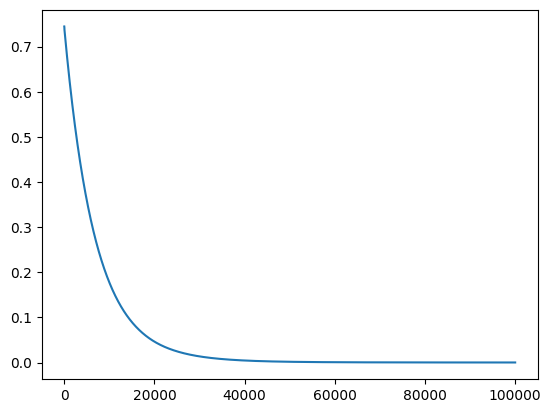

In [2]:
import matplotlib.pyplot as plt


plt.plot(MSE)

In [4]:
al._parameters, fn.alpha_

(array([0.52464954, 0.51333363, 0.52782926, 0.48370492, 0.52310412,
        0.5162634 , 0.52320396, 0.49070126, 0.52360092, 0.50922853,
        0.52354134, 0.52177013, 0.52103939, 0.5199353 , 0.52080733,
        0.51778024, 0.52179499, 0.5238046 , 0.52350281, 0.52397459]),
 0.5358033945403634)